In [21]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jupyter
import supabase
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
# get data
events_df = pd.read_csv("../data/events.csv")
event_attendance_df = pd.read_csv("../data/event_attendance.csv")

In [3]:
# simple checks

# event_attendance_df.info()
event_attendance_df.head()
# event_attendance_df.head()

,id,member_id,event_id,claimed_at
0,0388b812-c5f7-4d65-9da6-eda0a5a3f6a1,dc52c648-8784-4cf3-9ab4-5f6ce8a75748,03594c84-31e6-41eb-9182-e908ee1a5808,2025-11-25 02:49:40.194071+00
1,055a433f-a2fe-4101-ab11-bda12d11448b,89e7526f-f08f-4526-ada9-c953b0196867,8e47c78e-ad91-4585-bec8-56cc5950ab69,2025-11-13 22:31:00.149222+00
2,05f069ee-7304-4524-87db-e0ce39f540a2,44185564-87f0-4905-8d29-157521a8a4e9,f0f4d88d-d2cb-428d-86b0-5ab54c90382d,2025-10-11 12:00:16.028523+00
3,077c4777-7803-4d06-a600-4f21e1da3ad6,24069571-5213-4ef0-ba7a-f75ac94c4690,05713e78-b6db-457c-aa25-7ec5ad066300,2025-12-14 20:43:16.221208+00
4,098452e2-d792-4ca6-a0c9-85317c68466a,ce334cae-4951-4636-869c-cb5424b87290,8e47c78e-ad91-4585-bec8-56cc5950ab69,2025-11-13 22:16:59.064664+00


In [4]:
# Safe merge that can be run multiple times
if "total_attendees" not in events_df.columns:
    # Get attendance counts per event
    attendance_counts = event_attendance_df.groupby("event_id").size().reset_index(name="total_attendees")
    
    # Merge with events_df (only keeping the total_attendees column)
    events_df = events_df.merge(attendance_counts[["event_id", "total_attendees"]], left_on="id", right_on="event_id", how="left")
    
    # Fill NaN with 0 and convert to int
    events_df["total_attendees"] = events_df["total_attendees"].fillna(0).astype(int)
    
    # Optional: Remove the redundant event_id column if it was added
    if "event_id" in events_df.columns:
        events_df = events_df.drop("event_id", axis=1)

# Now you can safely rerun this cell multiple times without errors
print(f"Events with attendance data: {events_df['total_attendees'].sum()}")

Events with attendance data: 168


In [13]:
# check the new updated data and remove any unneeded columns
# events_df.head(20)

events_df = events_df.drop(columns=["id", "name", "code"], axis=1, errors="ignore")

events_df.head()

,date,points,end_time,start_time,food_present,is_virtual,total_attendees,date_local,start_time_local,end_time_local,weekday,month,day,start_hour,event_type_competition,event_type_fundraising,event_type_gbm,event_type_industry_speaker,event_type_workshop
0,2025-11-15 00:00:00+00:00,4,2025-11-16 00:00:00+00:00,2025-11-15 22:00:00+00:00,1,0,42,2025-11-14 19:00:00-05:00,2025-11-15 17:00:00-05:00,2025-11-15 19:00:00-05:00,4,11,14,17,False,True,False,False,False
1,2025-12-07 00:00:00+00:00,4,2025-12-08 00:00:00+00:00,2025-12-07 23:00:00+00:00,0,0,12,2025-12-06 19:00:00-05:00,2025-12-07 18:00:00-05:00,2025-12-07 19:00:00-05:00,5,12,6,18,True,False,False,False,False
2,2025-11-18 00:00:00+00:00,3,2025-11-19 01:00:00+00:00,2025-11-18 22:50:00+00:00,1,0,4,2025-11-17 19:00:00-05:00,2025-11-18 17:50:00-05:00,2025-11-18 20:00:00-05:00,0,11,17,17,False,False,False,False,True
3,2025-10-16 00:00:00+00:00,2,2025-10-16 23:15:00+00:00,2025-10-16 21:45:00+00:00,0,1,3,2025-10-15 20:00:00-04:00,2025-10-16 17:45:00-04:00,2025-10-16 19:15:00-04:00,2,10,15,17,False,False,False,True,False
4,2025-10-02 00:00:00+00:00,3,2025-10-02 23:45:00+00:00,2025-10-02 22:15:00+00:00,0,0,1,2025-10-01 20:00:00-04:00,2025-10-02 18:15:00-04:00,2025-10-02 19:45:00-04:00,2,10,1,18,False,False,False,False,False


In [16]:
# feature engineering - date and time

# turn boolean columns into int
events_df["is_virtual"] = events_df["is_virtual"].astype(int)
events_df["food_present"] = events_df["food_present"].astype(int)

# one hot encode the event_type column
if "event_type" in events_df.columns:
    events_df = pd.get_dummies(
        events_df,
        columns=["event_type"],
        drop_first=True
    )

# turn the date and time columns into a datetime object with utc timezone
events_df["date"] = pd.to_datetime(events_df["date"], utc=True)
events_df["start_time"] = pd.to_datetime(events_df["start_time"], utc=True)
events_df["end_time"] = pd.to_datetime(events_df["end_time"], utc=True)

# convert to local timezone (est)
events_df["date_local"] = events_df["date"].dt.tz_convert("US/Eastern")
events_df["start_time_local"] = events_df["start_time"].dt.tz_convert("US/Eastern")
events_df["end_time_local"] = events_df["end_time"].dt.tz_convert("US/Eastern")

# get the useful information from datetime objects
events_df["weekday"] = events_df["date_local"].dt.weekday
events_df["month"] = events_df["date_local"].dt.month
events_df["day"] = events_df["date_local"].dt.day
events_df["start_hour"] = events_df["start_time_local"].dt.hour

events_df.head()

,date,points,end_time,start_time,food_present,is_virtual,total_attendees,date_local,start_time_local,end_time_local,weekday,month,day,start_hour,event_type_competition,event_type_fundraising,event_type_gbm,event_type_industry_speaker,event_type_workshop
0,2025-11-15 00:00:00+00:00,4,2025-11-16 00:00:00+00:00,2025-11-15 22:00:00+00:00,1,0,42,2025-11-14 19:00:00-05:00,2025-11-15 17:00:00-05:00,2025-11-15 19:00:00-05:00,4,11,14,17,False,True,False,False,False
1,2025-12-07 00:00:00+00:00,4,2025-12-08 00:00:00+00:00,2025-12-07 23:00:00+00:00,0,0,12,2025-12-06 19:00:00-05:00,2025-12-07 18:00:00-05:00,2025-12-07 19:00:00-05:00,5,12,6,18,True,False,False,False,False
2,2025-11-18 00:00:00+00:00,3,2025-11-19 01:00:00+00:00,2025-11-18 22:50:00+00:00,1,0,4,2025-11-17 19:00:00-05:00,2025-11-18 17:50:00-05:00,2025-11-18 20:00:00-05:00,0,11,17,17,False,False,False,False,True
3,2025-10-16 00:00:00+00:00,2,2025-10-16 23:15:00+00:00,2025-10-16 21:45:00+00:00,0,1,3,2025-10-15 20:00:00-04:00,2025-10-16 17:45:00-04:00,2025-10-16 19:15:00-04:00,2,10,15,17,False,False,False,True,False
4,2025-10-02 00:00:00+00:00,3,2025-10-02 23:45:00+00:00,2025-10-02 22:15:00+00:00,0,0,1,2025-10-01 20:00:00-04:00,2025-10-02 18:15:00-04:00,2025-10-02 19:45:00-04:00,2,10,1,18,False,False,False,False,False


In [19]:
# define x and y variables (y is the target variable)

X = events_df.drop(columns=["date", "start_time", "end_time", "total_attendees", "date_local", "start_time_local", "end_time_local"])
y = events_df["total_attendees"]

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   points                       16 non-null     int64
 1   food_present                 16 non-null     int64
 2   is_virtual                   16 non-null     int64
 3   weekday                      16 non-null     int32
 4   month                        16 non-null     int32
 5   day                          16 non-null     int32
 6   start_hour                   16 non-null     int32
 7   event_type_competition       16 non-null     bool 
 8   event_type_fundraising       16 non-null     bool 
 9   event_type_gbm               16 non-null     bool 
 10  event_type_industry_speaker  16 non-null     bool 
 11  event_type_workshop          16 non-null     bool 
dtypes: bool(5), int32(4), int64(3)
memory usage: 848.0 bytes


In [23]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# fit the model with training data
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


MAE: 24.85807280134633
R2: -2.4161903915357676


Text(0, 0.5, 'Predicted Attendees')

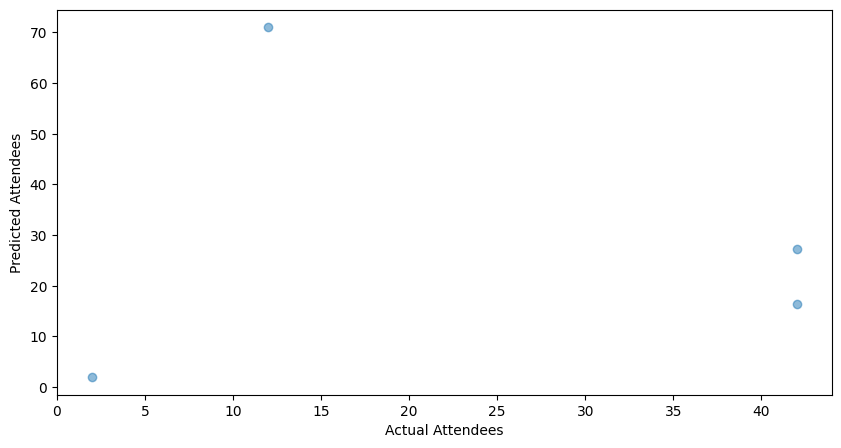

In [25]:
# evaluate the model

y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"R2: {r2_score(y_test, y_pred)}")

# plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Attendees")
plt.ylabel("Predicted Attendees")

In [ ]:
# predict a future event 
future_event = {
    "points": 2,
    "food_present": 1,
    "is_virtual": 0,
    "weekday": 2,        # Wednesday
    "month": 0,
    "day": 15,
    "start_hour": 17,
    "event_type_competition": 0,
    "event_type_fundraising": 0,
    "event_type_gbm": 1,          # <-- THIS is how you say "gbm"
    "event_type_industry_speaker": 0,
    "event_type_workshop": 0
}

# convert to dataframe
future_event_df = pd.DataFrame([future_event])